# Decision Analysis - Project 2 #

Daniel Jankowski 148257 <br>
Mateusz Małecki 148265

In [93]:
import pandas as pd
import numpy as np
from pulp import *
from typing import Tuple, List
from copy import deepcopy
import matplotlib.pyplot as plt

data = pd.read_csv("DA_database.csv", decimal=",")

In [94]:
data

,name,prestige,power,price,engine_size,colour_preference,fuel_consumption,mileage,production_year,automatic_gear_box
0,Seat Ibiza 1.2 white,1,90,34900,1.2,2,6.0,90000,2015,0
1,Seat Ibiza 1.4 green,1,85,27800,1.4,4,6.9,82000,2015,0
2,Skoda Fabia grey,4,75,31500,1.0,1,5.8,215000,2019,0
3,Nissan Note grey,3,80,28500,1.2,1,6.0,133000,2014,0
4,MINI Cooper 1.6 blue,7,175,27900,1.6,5,8.0,183000,2006,0
5,Opel Corsa white,4,75,28500,1.4,2,6.0,130000,2017,0
6,Toyota Yaris 1.3 grey,5,99,27300,1.3,1,6.5,125000,2012,0
7,Citroen DS3 red,3,82,27900,1.2,5,5.0,130000,2014,0
8,Volkswagen Polo 1.2 white,5,105,37000,1.2,2,6.9,106000,2013,0
9,Toyota Yaris 1.0 white,5,69,34000,1.0,2,5.0,184000,2016,0


In [95]:
# List of preference information comparisons
PREFERENCES = [
    (11, 4, "P"),
    (8, 17, "P"),
    (18, 9, "P"),
    (20, 15, "I"),
    (0, 1, "P"),
    (1, 3, "P"),
    (14, 19, "P"),
    (11, 3, "P"),
    (14, 21, "P"),
    (16, 3, "I"),
    (18, 14, "I"),
    (11, 2, "P"),
    (14, 6, "P"),
    (14, 11, "P"),
    (13, 19, "P"),
    (20, 16, "P"),
    (15, 10, "P"),
    (21, 10, "P"),
    (3, 19, "P"),
    (0, 5, "I"),
    (7, 6, "P"),
    (20, 21, "P"),
    (20, 2, "P"),
    (15, 7, "I"),
    (16, 21, "P"),
    (3, 21, "I"),
    (20, 11, "P"),
    (9, 20, "I"),
    (7, 9, "P"),
    (15, 9, "P"),
    (20, 9, "P")
]
print(f"Provided comparisons: {len(PREFERENCES)}/{int(len(data)*(len(data)-3)/2)}")

# Binary list with information of gain/cost type of criteria
GAIN_COST_FLAG = np.array([1,1,0,0,1,0,0,1,1])

# Number of breakpoints per criteria
NUMBER_ADD_BREAKPOINTS = [5, 7, 8, 4, 2, 8, 10, 3, 0]

Provided comparisons: 31/209


In [96]:
def make_breakpoints(_range, additional_breaks: int) -> List[int]:
    """Generate N equally distributed addtional breakpoints in some range of values

    :param _range: Minimal and maximum value for a criteria
    :type _range: Tuple[int, int]
    :param additional_breaks: Number of additional breakpoints between min and max value 
    :type additional_breaks: int
    :return: List of breakpoints
    :rtype: List
    """
    step = abs(_range[0]-_range[1]) / (additional_breaks+1)
    if (isinstance(_range[0], int)):
        return [int(min(_range) + i * step) for i in range(additional_breaks + 2)]
    else:
        return [round(min(_range) + i * step, 2) for i in range(additional_breaks + 2)]
    
def interp_in_LP(perf, breakpoints, u_variables, gain, idx):
    xv = breakpoints
    left = None
    right = None

    curr = float("inf")
    #finding left boundary
    for x in xv:
        if perf - x < curr and x < perf:
            curr = perf - x
            left = x

    #finding right boudary
    curr = float("inf")
    for x in xv:
        if x - perf < curr and x > perf:
            curr = x - perf
            right = x
    if not gain: left, right = right, left
    coef = (perf - left) / (right - perf)
    assert(left != None and right != None)
    left_v = u_variables[f"u{idx + 1}"][left]
    right_v = u_variables[f"u{idx + 1}"][right]
    return left_v + coef * (right_v - left_v)

In [97]:
def formulateUTALP(PREFERENCES, data, GAIN_COST_FLAG, NUMBER_ADD_BREAKPOINTS):
    NUM_CRITERIA = len(data.columns) - 1
    PREF_INFO_INDICES = set()
    for p in PREFERENCES:
        PREF_INFO_INDICES.add(p[0])
        PREF_INFO_INDICES.add(p[1])
    PREF_INFO_INDICES = sorted(list(PREF_INFO_INDICES))
    

    # min and max value for criterion
    CRITERIA_RANGES = []
    for col in data.columns[1:]:
        CRITERIA_RANGES.append([data[col].min(), data[col].max()])

    #creating LP problem
    model = LpProblem(name="Ordinal_Regression", sense=LpMinimize)

    # declaration of error variables (over and under estimations)
    error_plus_variables = LpVariable.dicts("plus", PREF_INFO_INDICES, lowBound=0)
    error_minus_variables = LpVariable.dicts("minus", PREF_INFO_INDICES, lowBound=0)

    # declaration of objective function 
    error_plus_sum = lpSum([error_plus_variables[i] * 1 for i in error_plus_variables])
    error_minus_sum = lpSum([error_minus_variables[i] * 1 for i in error_minus_variables])

    model += error_plus_sum + error_minus_sum
    
    
    # Declare variables for breakpoints
    # list which holds variables important for normalization constraint
    normalization_constraint_variables = []

    u_variables = dict()

    BREAKPOINTS = []

    for c in range(NUM_CRITERIA):
        breakpoints = make_breakpoints(tuple(CRITERIA_RANGES[c]), NUMBER_ADD_BREAKPOINTS[c])
        variables = LpVariable.dicts("u"+str(c+1), breakpoints, lowBound=0, upBound=1)
        if GAIN_COST_FLAG[c]: # if true then criterion is gain-type:
            # constraint that the worst performance = 0
            model += (variables[min(breakpoints)] == 0)
            # save the best variable which has to take a part in normalization constraint
            normalization_constraint_variables.append(variables[max(breakpoints)]) 
        else:
            model += (variables[max(breakpoints)] == 0)
            normalization_constraint_variables.append(variables[min(breakpoints)]) 
        BREAKPOINTS.append(breakpoints)
        u_variables["u"+str(c+1)] = variables
        
    normalization_expr = lpSum([var * 1 for var in normalization_constraint_variables])
    model += LpConstraint(e=normalization_expr, sense=0, name="Normalization_constraint", rhs=1)
    # Add to the model all "main" constraints w.r.t. to preference information

    for preference in PREFERENCES:
        alt1_inx, alt2_inx, type = preference
        alt1 = data.loc[alt1_inx, data.columns!='name'].values.flatten().tolist()
        alt2 = data.loc[alt2_inx, data.columns!='name'].values.flatten().tolist()
        a1_variables = []
        a2_variables = []
        for inx, (a1, a2) in enumerate(zip(alt1, alt2)):
            if a1 not in u_variables["u"+str(inx+1)]:
                # if value of the alternative for a given criteria is not present in the list already (it's not a breakpoint value), add it
                expr_a1 = interp_in_LP(a1, BREAKPOINTS[inx], u_variables, GAIN_COST_FLAG[inx], inx)#LpVariable("u"+str(inx+1)+"_"+str(a1), lowBound=0, upBound=1)
            else:
                expr_a1 = u_variables["u"+str(inx+1)][a1]
            a1_variables.append(expr_a1)
            if a2 not in u_variables["u"+str(inx+1)]:
                # if value of the alternative for a given criteria is not present in the list already (it's not a breakpoint value), add it
                expr_a2 = interp_in_LP(a2, BREAKPOINTS[inx], u_variables, GAIN_COST_FLAG[inx], inx) #LpVariable("u"+str(inx+1)+"_"+str(a2), lowBound=0, upBound=1)
            else:
                expr_a2 = u_variables["u"+str(inx+1)][a2]
            a2_variables.append(expr_a2)
        a1_sum = lpSum([_ * 1 for _ in a1_variables])
        a2_sum = lpSum([_ * 1 for _ in a2_variables])
        if type == "P":
            model += a1_sum - error_plus_variables[alt1_inx] + error_minus_variables[alt1_inx] - a2_sum + error_plus_variables[alt2_inx] -  error_minus_variables[alt2_inx] >= 1e-04
        else:
            model += a1_sum - error_plus_variables[alt1_inx] + error_minus_variables[alt1_inx] - a2_sum + error_plus_variables[alt2_inx] -  error_minus_variables[alt2_inx] == 0
    # Create constraints about monotonicity
    for inx, points in enumerate(BREAKPOINTS):
        if GAIN_COST_FLAG[inx]:
            for i in range(len(points)-1):
                model += u_variables["u"+str(inx+1)][points[i+1]] - u_variables["u"+str(inx+1)][points[i]] >= 0
        else:
            for i in range(len(points)-1):
                model += u_variables["u"+str(inx+1)][points[i]] - u_variables["u"+str(inx+1)][points[i+1]] >= 0
    return model

In [98]:
def findInconsistency(PREFERENCES, data, GAIN_COST_FLAG, NUMBER_ADD_BREAKPOINTS):
    model = LpProblem(name="Resolving_Inconsistency", sense=LpMinimize)
    normalization_constraint_variables = []

    NUM_CRITERIA = len(data.columns) - 1
    PREF_INFO_INDICES = set()
    for p in PREFERENCES:
        PREF_INFO_INDICES.add(p[0])
        PREF_INFO_INDICES.add(p[1])
    PREF_INFO_INDICES = sorted(list(PREF_INFO_INDICES))
    

    # min and max value for criterion
    CRITERIA_RANGES = []
    for col in data.columns[1:]:
        CRITERIA_RANGES.append([data[col].min(), data[col].max()])
    u_variables = dict()

    BREAKPOINTS = []

    for c in range(NUM_CRITERIA):
        breakpoints = make_breakpoints(tuple(CRITERIA_RANGES[c]), NUMBER_ADD_BREAKPOINTS[c])
        variables = LpVariable.dicts("u"+str(c+1), breakpoints, lowBound=0, upBound=1)
        if GAIN_COST_FLAG[c]: # if true then criterion is gain-type:
            # constraint that the worst performance = 0
            model += (variables[min(breakpoints)] == 0)
            # save the best variable which has to take a part in normalization constraint
            normalization_constraint_variables.append(variables[max(breakpoints)]) 
        else:
            model += (variables[max(breakpoints)] == 0)
            normalization_constraint_variables.append(variables[min(breakpoints)]) 
        BREAKPOINTS.append(breakpoints)
        u_variables["u"+str(c+1)] = variables
        
    normalization_expr = lpSum([var * 1 for var in normalization_constraint_variables])
    model += LpConstraint(e=normalization_expr, sense=0, name="Normalization_constraint", rhs=1)
    # Add to the model all "main" constraints w.r.t. to preference information
    binary_variables = []

    for preference in PREFERENCES:
        alt1_inx, alt2_inx, type = preference
        alt1 = data.loc[alt1_inx, data.columns!='name'].values.flatten().tolist()
        alt2 = data.loc[alt2_inx, data.columns!='name'].values.flatten().tolist()
        a1_variables = []
        a2_variables = []
        for inx, (a1, a2) in enumerate(zip(alt1, alt2)):
            if a1 not in u_variables["u"+str(inx+1)]:
                # if value of the alternative for a given criteria is not present in the list already (it's not a breakpoint value), add it
                expr_a1 = interp_in_LP(a1, BREAKPOINTS[inx], u_variables, GAIN_COST_FLAG[inx], inx)#LpVariable("u"+str(inx+1)+"_"+str(a1), lowBound=0, upBound=1)
            else:
                expr_a1 = u_variables["u"+str(inx+1)][a1]
            a1_variables.append(expr_a1)
            if a2 not in u_variables["u"+str(inx+1)]:
                # if value of the alternative for a given criteria is not present in the list already (it's not a breakpoint value), add it
                expr_a2 = interp_in_LP(a2, BREAKPOINTS[inx], u_variables, GAIN_COST_FLAG[inx], inx) #LpVariable("u"+str(inx+1)+"_"+str(a2), lowBound=0, upBound=1)
            else:
                expr_a2 = u_variables["u"+str(inx+1)][a2]
            a2_variables.append(expr_a2)
        a1_sum = lpSum([_ * 1 for _ in a1_variables])
        a2_sum = lpSum([_ * 1 for _ in a2_variables])
        binary_variable = LpVariable("V_"+str(alt1_inx)+"_"+str(alt2_inx), cat='Binary')
        binary_variables.append(binary_variable)
        if type == "P":
            model += a1_sum - a2_sum + binary_variable >= 1e-04
        else:
            model += a1_sum - a2_sum + binary_variable >= 0
            model += a2_sum - a1_sum + binary_variable >= 0
    for inx, points in enumerate(BREAKPOINTS):
        if GAIN_COST_FLAG[inx]:
            for i in range(len(points)-1):
                model += u_variables["u"+str(inx+1)][points[i+1]] - u_variables["u"+str(inx+1)][points[i]] >= 0
        else:
            for i in range(len(points)-1):
                model += u_variables["u"+str(inx+1)][points[i]] - u_variables["u"+str(inx+1)][points[i+1]] >= 0
    model += lpSum([bin_var * 1 for bin_var in binary_variables])
    return model

In [99]:
def interpolate(perf, points):
    values = {float(x.name.split("_")[1]) : x.varValue for x in points}
    if perf in values.keys(): return values[perf]

    f = sorted([(x[0], x[1]) for x in values.items()], key = lambda x: x[0])
    xp = [x[0] for x in f]
    fp = [x[1] for x in f]
    # print(xp, fp)
    return np.interp(perf, xp, fp)   

In [100]:
inc_model = formulateUTALP(PREFERENCES, data, GAIN_COST_FLAG, NUMBER_ADD_BREAKPOINTS)
inc_model

Ordinal_Regression:
MINIMIZE
1*minus_0 + 1*minus_1 + 1*minus_10 + 1*minus_11 + 1*minus_13 + 1*minus_14 + 1*minus_15 + 1*minus_16 + 1*minus_17 + 1*minus_18 + 1*minus_19 + 1*minus_2 + 1*minus_20 + 1*minus_21 + 1*minus_3 + 1*minus_4 + 1*minus_5 + 1*minus_6 + 1*minus_7 + 1*minus_8 + 1*minus_9 + 1*plus_0 + 1*plus_1 + 1*plus_10 + 1*plus_11 + 1*plus_13 + 1*plus_14 + 1*plus_15 + 1*plus_16 + 1*plus_17 + 1*plus_18 + 1*plus_19 + 1*plus_2 + 1*plus_20 + 1*plus_21 + 1*plus_3 + 1*plus_4 + 1*plus_5 + 1*plus_6 + 1*plus_7 + 1*plus_8 + 1*plus_9 + 0
SUBJECT TO
_C1: u1_1 = 0

_C2: u2_69 = 0

_C3: u3_40000 = 0

_C4: u4_4.2 = 0

_C5: u5_1 = 0

_C6: u6_15.0 = 0

_C7: u7_301000 = 0

_C8: u8_1977 = 0

_C9: u9_0 = 0

Normalization_constraint: u1_10 + u2_215 + u3_27300 + u4_1.0 + u5_5 + u6_5.0
 + u7_22100 + u8_2020 + u9_1 = 1

_C10: minus_11 - minus_4 - plus_11 + plus_4 + 0 u1_7 + 5 u2_105 + 4 u2_160
 - 5 u2_178 - 4 u2_87 - 1.35166666667 u3_27300 + 0.351666666667 u3_28711
 + u3_40000 + 0.213333333333 u4_1.0 - 0.2

In [101]:
status = inc_model.solve()
print(f"status: {inc_model.status}, {LpStatus[inc_model.status]}")
print(f"objective: {inc_model.objective.value()}")
assert(inc_model.status == -1)

status: -1, Infeasible
objective: 0.0


<b>For now the solution is infeasible, because some of the constraints are infeasible.</b>

We'll implement the model using <b>binary variables</b> to reject inconsistent preferences.

In [102]:
what_to_remove = findInconsistency(PREFERENCES, data, GAIN_COST_FLAG, NUMBER_ADD_BREAKPOINTS)
what_to_remove.solve()
print(f"status: {what_to_remove.status}, {LpStatus[what_to_remove.status]}")
print(f"objective: {what_to_remove.objective.value()}")
assert(what_to_remove.status == 1)

status: 1, Optimal
objective: 2.0


After solving the sub problem, we identified comparisons we should remove:

In [103]:
to_remove = []
for v in what_to_remove.variables():
    if "V" in v.name and v.varValue == 1.0:
        print(f"Comparison to remove: {v.name} = {v.varValue}")
        a, b, c = v.name.split("_")
        to_remove.append((int(b), int(c)))
to_remove

Comparison to remove: V_16_21 = 1.0
Comparison to remove: V_9_20 = 1.0


[(16, 21), (9, 20)]

Let's update our initial preferences, and remove above comparison:

In [104]:
NEW_PREFERENCES = deepcopy(PREFERENCES)
for x in PREFERENCES:
    if (x[0], x[1]) in to_remove:
        NEW_PREFERENCES.remove(x)
print(f"Provided comparisons: {len(NEW_PREFERENCES)}/{int(len(data)*(len(data)-3)/2)}")


Provided comparisons: 29/209


In [105]:
proper_model = formulateUTALP(NEW_PREFERENCES, data, GAIN_COST_FLAG, NUMBER_ADD_BREAKPOINTS)
proper_model.solve()
proper_model

Ordinal_Regression:
MINIMIZE
1*minus_0 + 1*minus_1 + 1*minus_10 + 1*minus_11 + 1*minus_13 + 1*minus_14 + 1*minus_15 + 1*minus_16 + 1*minus_17 + 1*minus_18 + 1*minus_19 + 1*minus_2 + 1*minus_20 + 1*minus_21 + 1*minus_3 + 1*minus_4 + 1*minus_5 + 1*minus_6 + 1*minus_7 + 1*minus_8 + 1*minus_9 + 1*plus_0 + 1*plus_1 + 1*plus_10 + 1*plus_11 + 1*plus_13 + 1*plus_14 + 1*plus_15 + 1*plus_16 + 1*plus_17 + 1*plus_18 + 1*plus_19 + 1*plus_2 + 1*plus_20 + 1*plus_21 + 1*plus_3 + 1*plus_4 + 1*plus_5 + 1*plus_6 + 1*plus_7 + 1*plus_8 + 1*plus_9 + 0
SUBJECT TO
_C1: u1_1 = 0

_C2: u2_69 = 0

_C3: u3_40000 = 0

_C4: u4_4.2 = 0

_C5: u5_1 = 0

_C6: u6_15.0 = 0

_C7: u7_301000 = 0

_C8: u8_1977 = 0

_C9: u9_0 = 0

Normalization_constraint: u1_10 + u2_215 + u3_27300 + u4_1.0 + u5_5 + u6_5.0
 + u7_22100 + u8_2020 + u9_1 = 1

_C10: minus_11 - minus_4 - plus_11 + plus_4 + 0 u1_7 + 5 u2_105 + 4 u2_160
 - 5 u2_178 - 4 u2_87 - 1.35166666667 u3_27300 + 0.351666666667 u3_28711
 + u3_40000 + 0.213333333333 u4_1.0 - 0.2

In [106]:
print(f"status: {proper_model.status}, {LpStatus[proper_model.status]}")
print(f"objective: {proper_model.objective.value()}")
assert(proper_model.status == 1)

status: 1, Optimal
objective: 0.0


In [107]:
# Values of the variables
for v in proper_model.variables():
    print(v.name, "=", v.varValue)

minus_0 = 0.0
minus_1 = 0.0
minus_10 = 0.0
minus_11 = 0.0
minus_13 = 0.0
minus_14 = 0.0
minus_15 = 0.0
minus_16 = 0.0
minus_17 = 0.0
minus_18 = 0.0
minus_19 = 0.0
minus_2 = 0.0
minus_20 = 0.0
minus_21 = 0.0
minus_3 = 0.0
minus_4 = 0.0
minus_5 = 0.0
minus_6 = 0.0
minus_7 = 0.0
minus_8 = 0.0
minus_9 = 0.0
plus_0 = 0.0
plus_1 = 0.0
plus_10 = 0.0
plus_11 = 0.0
plus_13 = 0.0
plus_14 = 0.0
plus_15 = 0.0
plus_16 = 0.0
plus_17 = 0.0
plus_18 = 0.0
plus_19 = 0.0
plus_2 = 0.0
plus_20 = 0.0
plus_21 = 0.0
plus_3 = 0.0
plus_4 = 0.0
plus_5 = 0.0
plus_6 = 0.0
plus_7 = 0.0
plus_8 = 0.0
plus_9 = 0.0
u1_1 = 0.0
u1_10 = 0.49932336
u1_2 = 0.0
u1_4 = 0.0
u1_5 = 0.0
u1_7 = 0.0
u1_8 = 2.4800761e-05
u2_105 = 0.0
u2_123 = 1.1661749e-05
u2_142 = 1.1661749e-05
u2_160 = 1.1661749e-05
u2_178 = 1.1661749e-05
u2_196 = 1.1661749e-05
u2_215 = 1.1661749e-05
u2_69 = 0.0
u2_87 = 0.0
u3_27300 = 0.00028834564
u3_28711 = 0.00028834564
u3_30122 = 0.00028834564
u3_31533 = 0.00025591978
u3_32944 = 0.00025591978
u3_34355 = 0.000

<b>The value of the objective function is 0.0, therefore UTA algorithm found the proper solution.</b>

In [108]:
def rank(vars, data):
    us = [x for x in vars if "u" in x.name and "plus" not in x.name and "minus" not in x.name]
    scores = []
    for i, name in enumerate(data["name"]):
        performance = data.loc[i, data.columns!='name'].values.flatten().tolist()
        score = 0
        for inx, a in enumerate(performance):
            score += interpolate(a, [x for x in us if str(inx+1) == x.name.split("_")[0][1:]])
        scores.append((name, score))
    return sorted(scores, key = lambda x : x[1], reverse=True)

def plotFunctions(vars, data):
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))
    us = [x for x in vars if "u" in x.name and "plus" not in x.name and "minus" not in x.name]
    x, y = 0, 0
    xlabels = ["prestige_points", "hp", "zloty", "cm3", "colour_points", "l/100km", "km", "year", ""]
    for i in range(len(data.columns)-1):
        points = [x for x in us if str(i+1) == x.name.split("_")[0][1:]]
        f = sorted([(float(x.name.split("_")[1]), x.varValue) for x in points], key = lambda x : x[0])
        xp = np.array([x[0] for x in f])
        fp = np.array([x[1] for x in f])
        fp = fp / max(fp)
        axs[x, y].plot(xp, fp)
        axs[x, y].set_title(data.columns[1:][i])
        axs[x, y].set_xlabel(xlabels[i])
        y += 1
        if y==3:
            x += 1
            y = 0
    plt.tight_layout()
    plt.show()

In [109]:
ranking = rank(proper_model.variables(), data)
for x in ranking:
    print(x)
print(f"Sum of all performances: {sum([x[1] for x in ranking])}")

('Ford Fiesta blue', 0.5004939610464288)
('Peugeot 208 red', 0.50044343930725)
('Audi A1 red', 0.5004082245940101)
('Audi A1 black', 0.500381723703274)
('Citroen DS3 red', 0.5003685328769786)
('Toyota Yaris 1.0 white', 0.5002985898690909)
('Volkswagen Polo 1.2 red', 0.5001910410172242)
('Toyota Prius black', 0.5001720190154545)
('Seat Ibiza 1.4 green', 0.5001662671598636)
('Seat Ibiza 1.2 white', 0.5001557732335866)
('Opel Corsa white', 0.5001549280343833)
('Jaguar xj red', 0.500146831207)
('Volkswagen Polo 1.2 white', 0.5001317886281591)
('Hyundai i20 white', 0.5001208140494049)
('Abarth Grande Punto white', 0.5000232136125)
('MINI Cooper 1.6 blue', 0.5000153817453249)
('Skoda Fabia grey', 0.49996051842090977)
('Alfa Romeo Giuletta white', 0.49994091362656207)
('Nissan Note grey', 0.49993192579985846)
('Toyota Yaris 1.3 grey', 0.49990259967447087)
('MINI Cooper 1.5 grey', 0.499604644610684)
('Mercedes w116 brown', 0.250224961591653)
Sum of all performances: 10.753238092824072


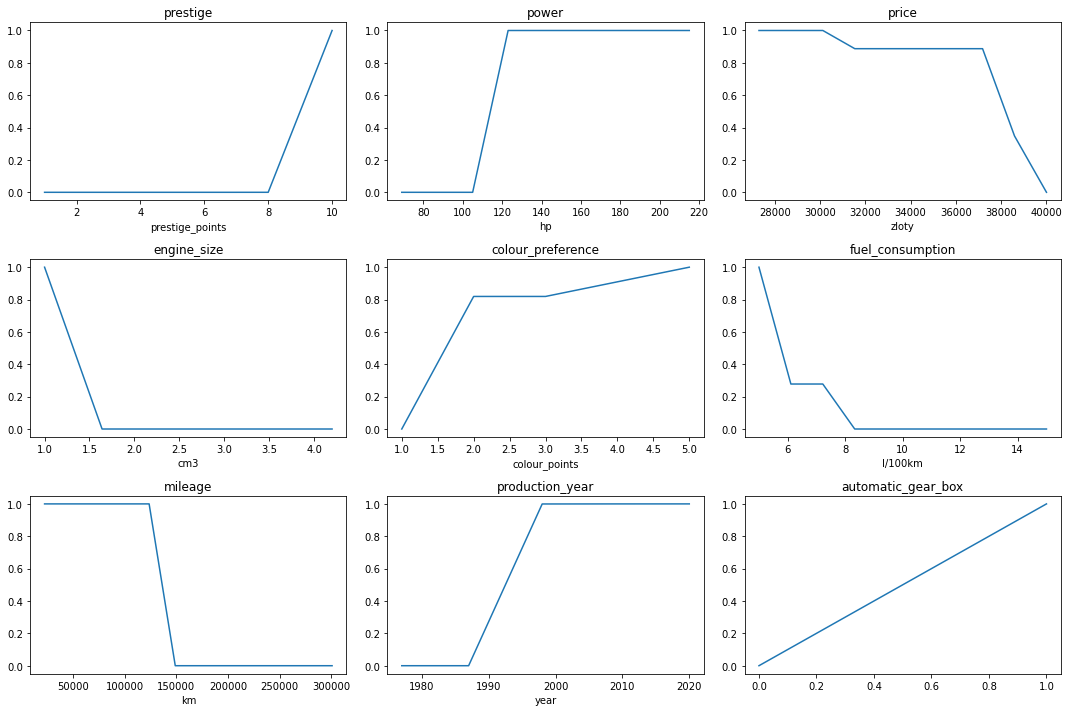

In [110]:
plotFunctions(proper_model.variables(), data)

## Comparison of UTA and Promethee II rankings ##

In [111]:
# Read promethee II ranking from .json file
import json

with open('prometheeII.json') as file:
    promethee = json.load(file)

In [112]:
# Mapping between alternative name and its index
name2inx = pd.Series(data.name.values).to_dict()
name2inx = {v: k for k, v in name2inx.items()}
name2inx

{'Seat Ibiza 1.2 white': 0,
 'Seat Ibiza 1.4 green': 1,
 'Skoda Fabia grey': 2,
 'Nissan Note grey': 3,
 'MINI Cooper 1.6 blue': 4,
 'Opel Corsa white': 5,
 'Toyota Yaris 1.3 grey': 6,
 'Citroen DS3 red': 7,
 'Volkswagen Polo 1.2 white': 8,
 'Toyota Yaris 1.0 white': 9,
 'Abarth Grande Punto white': 10,
 'MINI Cooper 1.5 grey': 11,
 'Volkswagen Polo 1.2 red': 12,
 'Hyundai i20 white': 13,
 'Peugeot 208 red': 14,
 'Audi A1 black': 15,
 'Alfa Romeo Giuletta white': 16,
 'Toyota Prius black': 17,
 'Ford Fiesta blue': 18,
 'Mercedes w116 brown': 19,
 'Audi A1 red': 20,
 'Jaguar xj red': 21}

In [113]:
# Create preference matrix for promethee II ranking
promethee_matrix = np.zeros(shape=(22,22))

for key, value in promethee.items():
    inx_alternative = name2inx[key]
    outranked_alternative_indices = [name2inx[outranked] for outranked in value]
    np.put(promethee_matrix[inx_alternative], outranked_alternative_indices, 1)

In [114]:
# Compute preference matrix for UTA method ranking
uta_matrix = np.zeros(shape=(22,22))

for inx, (name, score) in enumerate(ranking):
    inx_alternative = name2inx[name]
    outranked_indices = []
    indifference_indices = []
    for inx1, (name1, score1) in enumerate(ranking):
        if inx == inx1:
            continue
        if score > score1:
            outranked_indices.append(name2inx[name1])
        if score == score1:
            indifference_indices.append(name2inx[name1])
    np.put(uta_matrix[inx_alternative], outranked_indices, 1)
    np.put(uta_matrix[inx_alternative], indifference_indices, 0.5)

In [115]:
def compute_kendall_tau(rank1: np.array, rank2: np.array) -> float:
    ranking_difference = np.absolute(rank1 - rank2)
    kendal_distance = ranking_difference.sum() / 2.0
    kendall_tau = 1.0 - (4.0*(kendal_distance/(ranking_difference.shape[0]*(ranking_difference.shape[0]-1))))
    return kendall_tau

In [116]:
compute_kendall_tau(promethee_matrix, uta_matrix)

0.3939393939393939

Kendall tau express the consistency of two rankings in the range [-1, 1], where -1 means that both ranking are totally inconsitent and 1 that they agree with each other. The Kendall tau value in our case is equal to almost 0.4 which tells us that both rankings for Promethee II and UTA methods are quite consistent.

In case of Promethee II method the best alternative was Peugeot 208 red and then Ford Fiesta blue. In case of UTA method those two alternatives also were the best, however in different order. Here, Ford Fiesta was rank as the best choice and with a little bit lower score Peugeot obtained the second place. 

Both rankings also agreed in case of the worst alternative that was Mercedes w116 brown.

The greatest impact on the obtained results had the <b>production year</b> of the car. Since this criterion is quite important for the DM, in case of Promethee II the weight of it was high. Here, for the UTA method this criterion was also significant, since the weight of it was the highest among all of the criteria and was equal to almost 0.5.